# CycleGAN 실습

In [1]:
# pyTorch 관련 된 라이브러리.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # optimization에 관한 모듈.
import torchvision # 이미지 관련 전처리, pretrained된 모델, 데이터 로딩에 관한 패키지입니다.
import torchvision.datasets as datasets
import torchvision.transforms as T # 이미지 전처리 모듈입니다.
from torch.utils import data

# 기타 필요한 라이브러리.
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### CycleGAN


![CycleGAN](https://github.com/yunjey/mnist-svhn-transfer/blob/master/gif/cyclegan.png?raw=true)

## Data Loader 불러오기
cycleGAN의 경우 두 가지 서로 다른 도메인의 데이터(MNIST, SVHN)가 필요합니다. 모델이 트레이닝 된 이후에는 우리는 MNIST를 SVHN으로 바꾸거나 SVHN 데이터를 MNIST로 바꿀 수 있습니다.

In [2]:
# ========================  MNIST 데이터 함수. ======================== #

def MNIST_DATA(root='./data/', download=True, batch_size=32, num_worker=4):
    print ("[+] Get the MNIST DATA")
    """
    torchvision.dataset 에는 우리가 많이 사용하는 데이터들을 쉽게 사용할 수 있도록 되어 있습니다. 
    Machine Learning 에서 Hello world 라고 불리는 Mnist 데이터를 사용해 보겠습니다.
    """
    transform = T.Compose([T.Resize(32), # 32 x 32로 변환
                           T.ToTensor()])
    
    mnist_train = datasets.MNIST(root = root,  #root 는 데이터의 저장 위치 입니다. 
                                 train = True, #Train 은 이 데이터가 train 데이터인지 아닌지에 대한 정보입니다. 
                                 transform = transform,
                                 download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 
    mnist_test = datasets.MNIST(root = root,
                                train = False,  # Test Data를 가져오기에 Train =False 를 줘야 합니다. 
                                transform = transform,
                                download = True)
    """
    Data Loader 는 데이터와 batch size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 batch size 만큼 반환해주는 iterator입니다. 
    * Practical Guide : Batch size 는 어느정도가 좋나요? -- 클 수록 좋다는 소리가 있습니다. 하지만 gpu memeory 사이즈 한계에 의해 기본적으로 batch size 가 
    커질 수록 학습에 사용되는 gpu memory 사이즈가 큽니다. (Activation map을 저장해야 하기 때문입니다.) 기본적으로 2의 배수로 저장하는 것이 좋습니다.(Bit size 관련) 
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보입니다. 여기서는 Training DATA를 제공합니다. 
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 합니다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보입니다. 
                                      shuffle =True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼칩니다. 꼭 True 를 줘야 합니다. 
                                      num_workers = num_worker) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보입니다. 

    testDataLoader = data.DataLoader(dataset = mnist_test, # Test Data Loader 이므로 Test Data를 인자로 전달해줍니다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어줍니다. 
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 줍니다. 
                                     num_workers = num_worker) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train, mnist_test, trainDataLoader, testDataLoader


# ======================== SVHN 데이터 함수. ======================== #  

def SVHN_DATA(root='./data/', download =True, batch_size=32, num_worker=4):

    print ("[+] Get the SVHN DATA")
    """
    The Street View House Numbers(SVHN) 데이터 셋은 길거리에서 집 번호들을 찍은 데이터 셋 입니다. 
    SVHN은 MNIST와 마찬가지로 숫자 데이터셋이나 구조가 MNIST정도로 단순하지 않고 색깔 등이 있는 현실 이미지 입니다.
    """
    transform = T.Compose([T.Resize(32), # 32 x 32로 변환
                           T.ToTensor()])
    
    svhn_train = datasets.SVHN(root = root,  #root 는 데이터의 저장 위치 입니다. 
                               split = 'train', # SVHN 데이터의 경우 'split' argument로 train/test를 지정해 줍니다. 
                               transform = transform, # 얻어낸 데이터를 Resize 해주고, Tensor로 변환해 줍니다. 
                               download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 

    svhn_test = datasets.SVHN(root = root,
                              split = 'test',  # SVHN 데이터의 경우 'split' argument로 train/test를 지정해 줍니다. 
                              transform = transform,
                              download = True)
    
    """
    Data Loader 는 데이터와 batch size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 batch size 만큼 반환해주는 iterator입니다. 
    """
    trainDataLoader = data.DataLoader(dataset = svhn_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보입니다. 여기서는 Training DATA를 제공합니다. 
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 합니다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보입니다. 
                                      shuffle =True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼칩니다. 꼭 True 를 줘야 합니다. 
                                      num_workers = num_worker) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보입니다. 

    testDataLoader = data.DataLoader(dataset = svhn_test, # Test Data Loader 이므로 Test Data를 인자로 전달해줍니다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어줍니다. 
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 줍니다. 
                                     num_workers = num_worker) #
    print ("[+] Finished loading data & Preprocessing")
    return svhn_train, svhn_test, trainDataLoader, testDataLoader

In [3]:
# Dataloader들을 불러옵니다.
mnist_trainset, mnist_testset, mnist_trainloader, mnist_testloader = MNIST_DATA(batch_size = 4, num_worker=4) 
svhn_trainset, svhn_testset, svhn_trainloader, svhn_testloader = SVHN_DATA(batch_size = 4, num_worker=4) 

0.00B [00:00, ?B/s]

[+] Get the MNIST DATA


9.92MB [00:02, 3.59MB/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0.00B [00:00, ?B/s]

32.8kB [00:00, 62.6kB/s]                   
0.00B [00:00, ?B/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1.65MB [00:01, 1.24MB/s]                            


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


0.00B [00:00, ?B/s]

8.19kB [00:00, 18.9kB/s]                   


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...


0.00B [00:00, ?B/s]

Done!
[+] Finished loading data & Preprocessing
[+] Get the SVHN DATA


100%|█████████▉| 182M/182M [00:45<00:00, 3.74MB/s] 
0.00B [00:00, ?B/s]


  0%|          | 0.00/64.3M [00:00<?, ?B/s]
  0%|          | 16.4k/64.3M [00:00<08:30, 126kB/s]
  0%|          | 41.0k/64.3M [00:00<07:39, 140kB/s]
182MB [00:50, 3.64MB/s]                           ]
  0%|          | 123k/64.3M [00:00<05:35, 191kB/s] Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/nas1_userB/sunghyun/anaconda3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/nas1_userB/sunghyun/anaconda3/lib/python3.7/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/nas1_userB/sunghyun/anaconda3/lib/python3.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

64.3MB [00:21, 2.96MB/s]                            


[+] Finished loading data & Preprocessing


## MNIST, SVHN 데이터 확인

In [4]:
def show_images_by_class(dataset, cmap=None):
    ''' 각 데이터 셋에서 0-9 숫자를 찾아서 프린트 해보겠습니다. '''
    per_class_index = []
    try:
        labels = dataset.targets # dataset의 레이블 정보를 배웁니다.
    except:
        labels = dataset.labels 
  
    for idx in range(10):
        try:
            per_class_index += [(labels == idx).nonzero()[1].item()]
        except:
            per_class_index += [(labels == idx).nonzero()[0][1].item()]

    images = dataset.data[torch.Tensor(per_class_index).long()]
  
    plt.figure(figsize=(16,160)) # 세로 사이즈 20, 가로 사이즈 20*10  
  
    for a in range(1, 11):      
        plt.subplot(1, 10, a)
        try:
            plt.imshow(images[a-1], cmap)
        except:
            plt.imshow(images[a-1].transpose(1,2,0), cmap)
        plt.xticks([])
        plt.yticks([])  
    plt.show()  

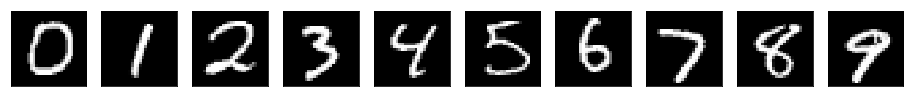

In [5]:
show_images_by_class(mnist_testset, plt.cm.gray)

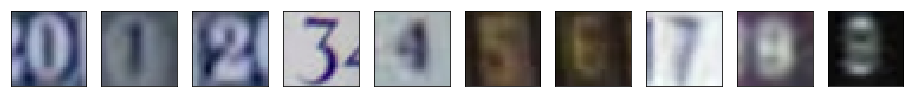

In [6]:
show_images_by_class(svhn_testset)

## Generator, Discriminator

In [7]:
'''
코드 단순화를 위한 함수들을 정의해 줍니다.
'''

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 convolution block 생성을 위한 함수입니다.
    Conv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    layers = []
    
    # Conv.
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
                
    return nn.Sequential(*layers)
  
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 deconvolution block 생성을 위한 함수입니다.
    Deconv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
                
    return nn.Sequential(*layers)

In [10]:
'''
Generator와 Discriminator를 선언해 줍니다. 
이 때 MNIST는 흑백 이미지이므로 채널이 1이라는 점과 SVHN은 컬러 이미지이므로 채널이 3이라는 것에 주의합니다!!! 
'''

class Generator(nn.Module):
    """ Generator. """
    def __init__(self, in_dim=1, out_dim=3):
        super(Generator, self).__init__()
        # encoding blocks
        self.conv1 = conv(in_dim, 64, 4)
        self.conv2 = conv(64, 64*2, 4)
        
        # intermediate blocks
        self.conv3 = conv(64*2, 64*2, 3, 1, 1)
        self.conv4 = conv(64*2, 64*2, 3, 1, 1)
        
        # decoding blocks
        self.deconv1 = deconv(64*2, 64, 4)
        self.deconv2 = deconv(64, out_dim, 4, bn=False, activation='tanh')
        
    def forward(self, x):
        out = self.conv1(x)      # (B, 64, 16, 16)
        out = self.conv2(out)    # (B, 128, 8, 8)
        
        out = self.conv3(out)    # (B, 128, 8, 8)
        out = self.conv4(out)    # (B, 128, 8, 8)
        
        out = self.deconv1(out)  # (B, 64, 16, 16)
        out = self.deconv2(out)  # (B, out_dim, 32, 32)
        return out


class Discriminator(nn.Module):
    """ Discriminator. """
    def __init__(self, in_dim=1):
        super(Discriminator, self).__init__()
        self.conv1 = conv(in_dim, 64, 4, bn=False)
        self.conv2 = conv(64, 64*2, 4)
        self.conv3 = conv(64*2, 64*4, 4)
        self.fc = conv(64*4, 1, 4, 1, 0, bn=False, activation='none')
        
    def forward(self, x):
        out = self.conv1(x)    # (B, 64, 16, 16)
        out = self.conv2(out)  # (B, 128, 8, 8)
        out = self.conv3(out)  # (B, 256, 4, 4)
        out = self.fc(out).squeeze()
        out = torch.sigmoid(out)
        return out


## 학습을 위한 사전 모델/optimizer 선언 & 기타준비

In [11]:
# 모델 선언 및 train모드로 만들어 줍니다.
G_ms = Generator(in_dim=1, out_dim=3).train().cuda()
G_sm = Generator(in_dim=3, out_dim=1).train().cuda()
D_m = Discriminator(in_dim=1).train().cuda()
D_s = Discriminator(in_dim=3).train().cuda()

# Optimizer 선언
g_optimizer = optim.Adam(list(G_ms.parameters()) + list(G_sm.parameters()), lr=0.0002, betas=(0.5, 0.99))
d_optimizer = optim.Adam(list(D_m.parameters()) + list(D_s.parameters()), lr=0.0002, betas=(0.5, 0.99))

# Fixed된 이미지를 프린팅하는 함수
def show_images(images):
    print_list = []
    for i in range(2):
        print_list += [images[0][i], images[1][i], images[2][i]]
  
    for i in range(2):
        print_list += [images[3][i], images[4][i], images[5][i]] 
    plt.figure(figsize=(8,14)) # 세로 사이즈 40, 가로 사이즈 20*3
  
    for a in range(1, 7):
        target_img = print_list[a-1]
        if target_img.shape[0] == 3:
            target_img = target_img.transpose(1, 2, 0)
            cmap = None
        else:
            target_img = target_img.transpose(1, 2, 0).squeeze()
            cmap = plt.cm.gray
        plt.subplot(4, 3, a)
        plt.imshow(target_img, cmap)
        plt.xticks([])
        plt.yticks([])
    for a in range(7, 13):
        target_img = print_list[a-1]
        if target_img.shape[0] == 3:
            target_img = target_img.transpose(1, 2, 0)
            cmap = None
        else:
            target_img = target_img.transpose(1, 2, 0).squeeze()
            cmap = plt.cm.gray
        plt.subplot(4, 3, a)
        plt.imshow(target_img, cmap)
        plt.xticks([])
        plt.yticks([])      
    plt.show()    

## Training CycleGAN 

여기서의 loss는 크게 4가지로 나누어 집니다.

- D: Real images들을 1로 분류하기 위한 loss (d_loss_real)
- D: Fake images들을 0로 분류하기 위한 loss (d_loss_fake)
- G: D를 속이는 Fake images들을 만들기 위한 loss (D에서 1로 분류함)(g_loss (1))
- G: 다시 돌아 갔을 때 reconstruction을 위한 cycle loss (g_loss (2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step[1000/10000], d_real_loss: 0.1072, d_fake_loss: 0.2970, g_loss: 0.9996


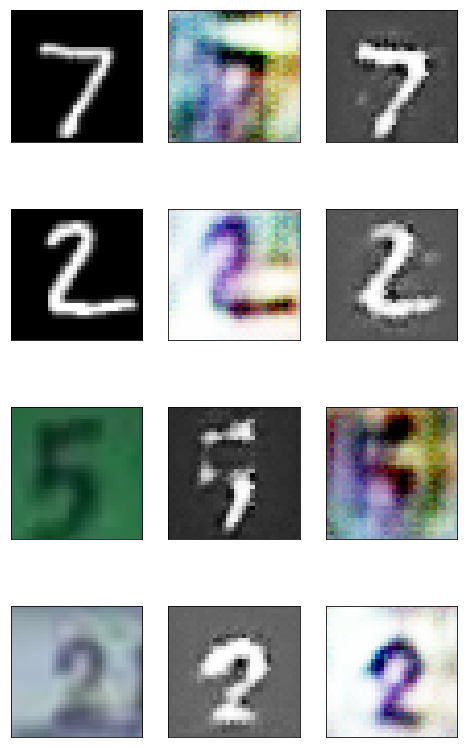

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step[2000/10000], d_real_loss: 0.0040, d_fake_loss: 0.0282, g_loss: 1.0104


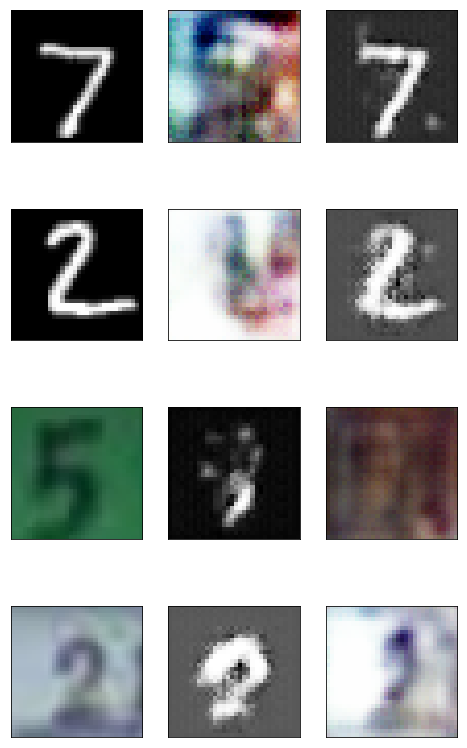

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step[3000/10000], d_real_loss: 0.0863, d_fake_loss: 0.0162, g_loss: 1.0141


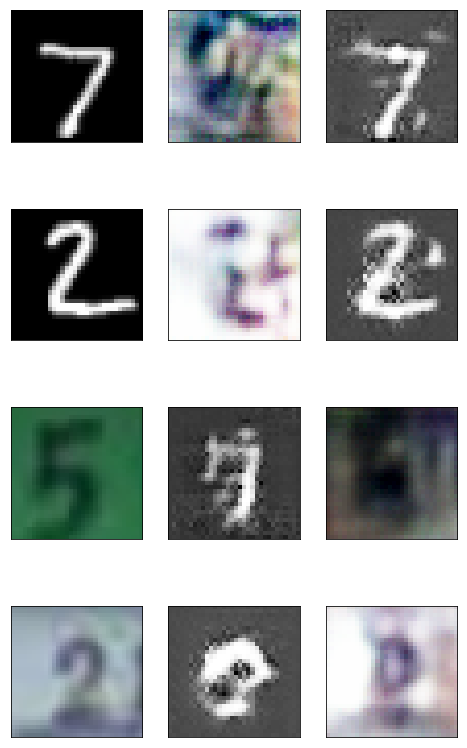

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step[4000/10000], d_real_loss: 0.1576, d_fake_loss: 0.0060, g_loss: 1.0111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


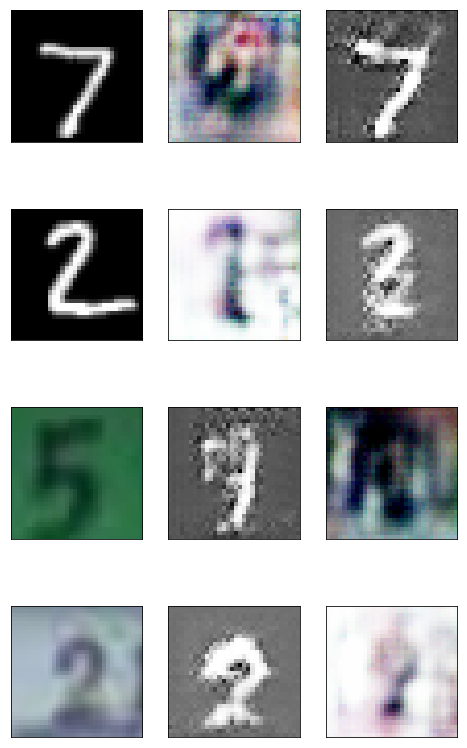

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step[5000/10000], d_real_loss: 0.1912, d_fake_loss: 0.0279, g_loss: 1.0184


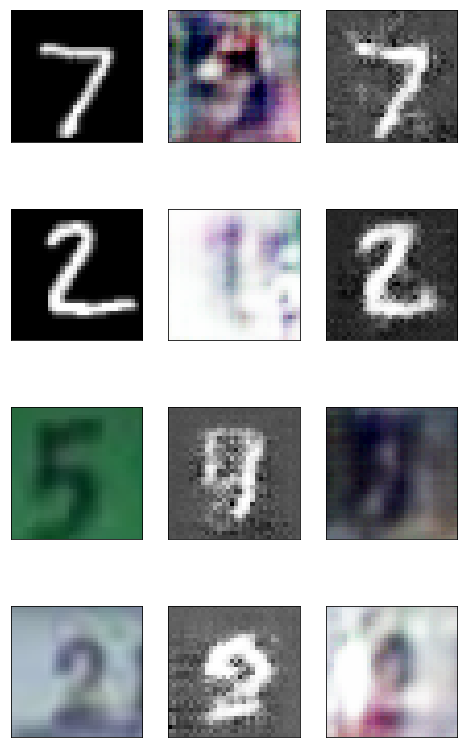

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step[6000/10000], d_real_loss: 0.0889, d_fake_loss: 0.1254, g_loss: 1.0045


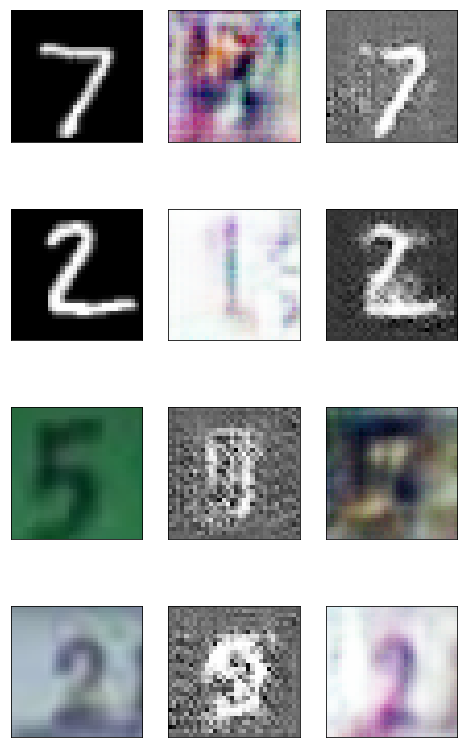

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step[7000/10000], d_real_loss: 0.0039, d_fake_loss: 0.0249, g_loss: 1.0102


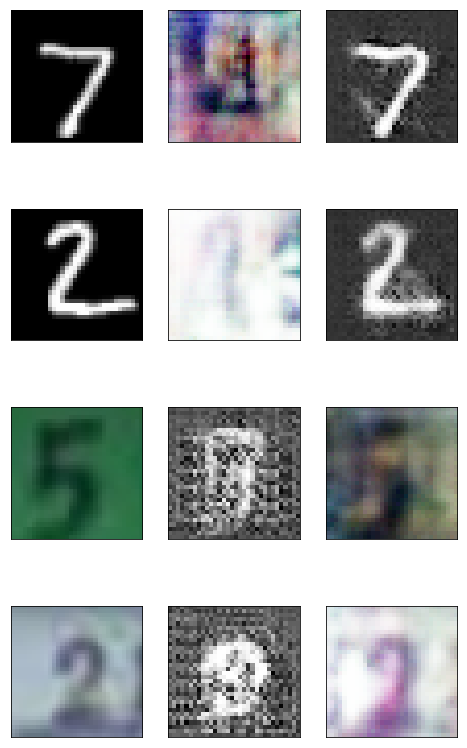

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step[8000/10000], d_real_loss: 0.0114, d_fake_loss: 0.0012, g_loss: 1.0057


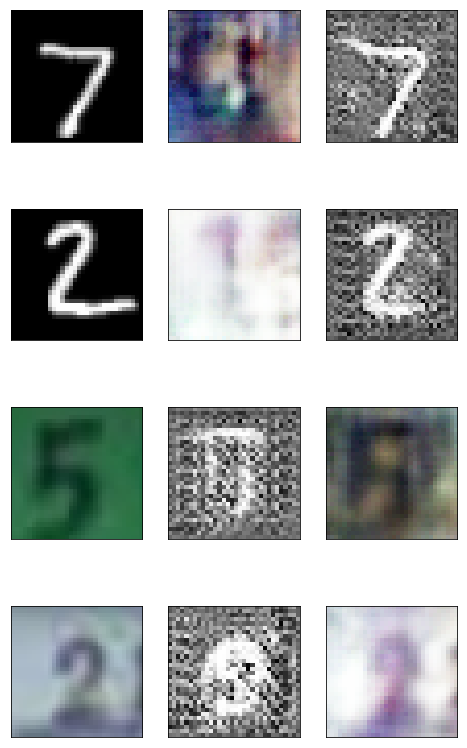

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step[9000/10000], d_real_loss: 0.0170, d_fake_loss: 0.0035, g_loss: 1.0033


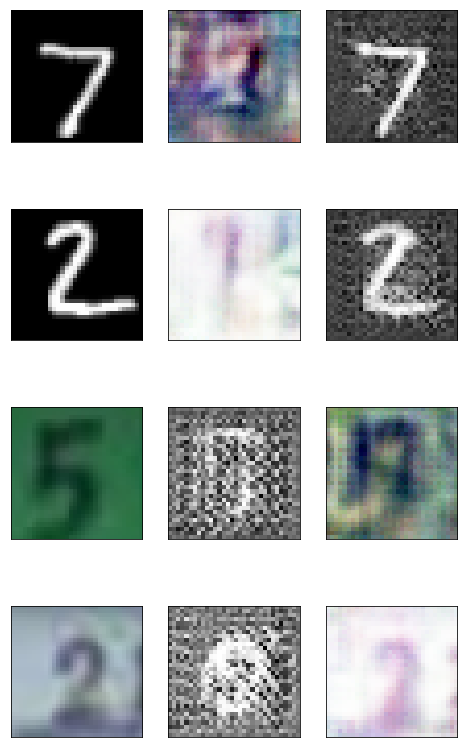

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step[10000/10000], d_real_loss: 0.0157, d_fake_loss: 0.0133, g_loss: 1.0033


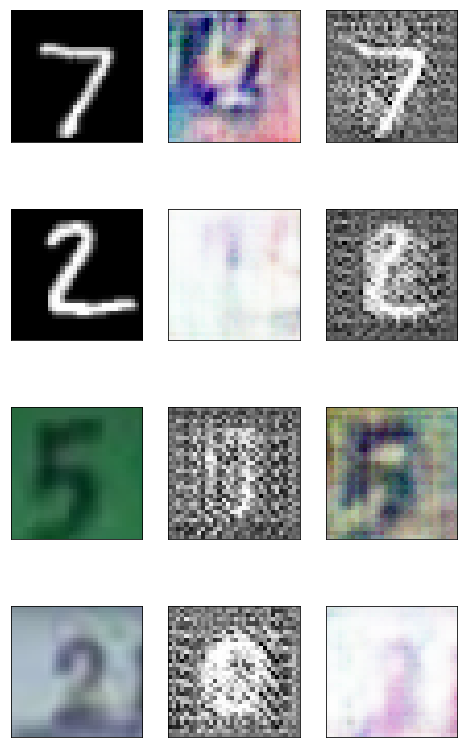

In [12]:
# Iteration 수 선언
iters = 50000

# trainig 과정에서 생성되는 이미지가 어떻게 변화하는지 볼 수 있도록 고정된 데이터를 가지고 있으면 좋습니다.
mnist_iter = iter(mnist_testloader)
svhn_iter = iter(svhn_testloader)

# 각 도메인별로 2개만 생성해 보겠습니다 
fixed_mnist = next(mnist_iter)[0][:2].cuda()
fixed_svhn = next(svhn_iter)[0][:2].cuda()

for i in range(iters):
    # 각 도메인의 데이터들을 불러와 줍니다.
    try:
        mnist, m_labels = next(mnist_iter) 
        svhn, s_labels = next(svhn_iter)
    except:
        mnist_iter = iter(mnist_testloader)
        svhn_iter = iter(svhn_testloader)
        mnist, m_labels = next(mnist_iter) 
        svhn, s_labels = next(svhn_iter)
    
    # To GPU
    mnist = mnist.cuda()
    m_labels = m_labels.cuda()
    svhn = svhn.cuda()
    s_labels = s_labels.cuda()
    
    #============= Train the discriminator =============#

    # Real images를 통해 D를 트레이닝 합니다.
    out = D_m(mnist)
    d_loss_mnist = torch.mean((out-1)**2)

    out = D_s(svhn)
    d_loss_svhn = torch.mean((out-1)**2)

    d_real_loss = d_loss_mnist + d_loss_svhn
  
    d_optimizer.zero_grad()
    d_real_loss.backward()
    d_optimizer.step()

    # Fake images = generated images를 통해 D를 트레이닝 합니다.
    fake_svhn = G_ms(mnist)
    out = D_s(fake_svhn)
    d_loss_mnist = torch.mean(out**2)

    fake_mnist = G_sm(svhn)
    out = D_m(fake_mnist)
    d_loss_svhn = torch.mean(out**2)

    d_fake_loss = d_loss_mnist + d_loss_svhn
  
    d_optimizer.zero_grad()
    d_fake_loss.backward()
    d_optimizer.step()

    #=============== Train the generator ===============#

    # mnist-svhn-mnist cycle loss를 발생 시킵니다.
    fake_svhn = G_ms(mnist)
    out = D_s(fake_svhn)
    recon_mnist = G_sm(fake_svhn)
  
    g_loss = torch.mean((out-1)**2) # Discriminator를 속이도록 gradient 정보가 흐를 수 있습니다. 
    g_loss += torch.mean((mnist - recon_mnist)**2) # MNIST를 다시 만들어 내야 합니다
  
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # svhn-mnist-svhn loss를 발생 시킵니다.
    fake_mnist = G_sm(svhn)
    out = D_m(fake_mnist)
    recon_svhn = G_ms(fake_mnist)

    g_loss = torch.mean((out-1)**2) # Discriminator를 속이도록 gradient 정보가 흐를 수 있습니다.
    g_loss += torch.mean((svhn - recon_svhn)**2) # SVHN를 다시 만들어 내야 합니다

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # print the log info
    if (i+1) % 1000 == 0:    
        # fixed image 로 이미지 생성
        mnist_to_svhn = G_ms(fixed_mnist)
        mnist_recon = G_sm(mnist_to_svhn) 

        svhn_to_mnist = G_sm(fixed_svhn)
        svhn_recon = G_ms(svhn_to_mnist)

        print('======================================================================================================')
        print('Step[%d/%d], d_real_loss: %.4f, d_fake_loss: %.4f, g_loss: %.4f' 
                  %(i+1, iters, d_real_loss.item(), d_fake_loss.item(), g_loss.item()))
        print('======================================================================================================')
        show_images([fixed_mnist.detach().cpu().numpy(), mnist_to_svhn.detach().cpu().numpy(), mnist_recon.detach().cpu().numpy()
                        ,fixed_svhn.detach().cpu().numpy(), svhn_to_mnist.detach().cpu().numpy(), svhn_recon.detach().cpu().numpy()])

In [0]:
torch.save(G.state_dict(),'./model/cyclegan_generator.pckl')
torch.save(D.state_dict(),'./model/cyclegan_discriminator.pckl')